In [9]:
# Requirements
%pip install numpy pandas matplotlib scipy scikit-learn statsmodels holidays xgboost jinja2 ipympl plotly
%pip install --upgrade nbformat ipywidgets 
%load_ext ipympl                 
%matplotlib widget               

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
The ipympl module is not an IPython extension.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import holidays
from sklearn.metrics import r2_score
import plotly.graph_objects as go
import importlib, plotly.io as pio
importlib.reload(pio)
from xgboost import XGBRegressor
_xgb_available = True

plt.style.use('ggplot')


In [11]:

# Data Processing
def load_raw(path: str):
    df = pd.read_csv(path, sep=';', encoding='utf-8', dtype=str)
    df.columns = ['Tarih', 'Saat', 'Tüketim Miktarı (MWh)']
    df['Tüketim Miktarı (MWh)'] = (df['Tüketim Miktarı (MWh)']
         .str.replace('.', '', regex=False)
         .str.replace(',', '.', regex=False))
    df['Tüketim Miktarı (MWh)'] = pd.to_numeric(df['Tüketim Miktarı (MWh)'], errors='coerce')
    df['Tarih'] = pd.to_datetime(df['Tarih'], format='%d.%m.%Y', errors='coerce')
    df.dropna(subset=['Tarih', 'Tüketim Miktarı (MWh)'], inplace=True)
    return df

def aggregate_daily(df):
    out = (df.groupby('Tarih', as_index=False)['Tüketim Miktarı (MWh)'].sum()
             .rename(columns={'Tarih':'Date','Tüketim Miktarı (MWh)':'consumption_mwh'}))
    out.sort_values('Date', inplace=True)
    return out

def add_calendar_features(df):
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['is_weekend']  = df['day_of_week'].isin([5,6]).astype(int)
    df['month']       = df['Date'].dt.month
    df['day_of_year'] = df['Date'].dt.dayofyear
    df['sin_doy'] = np.sin(2*np.pi*df['day_of_year']/365)
    df['cos_doy'] = np.cos(2*np.pi*df['day_of_year']/365)
    tr_holidays = holidays.Turkey(years=range(df['Date'].dt.year.min(),
                                              df['Date'].dt.year.max()+1))
    df['is_holiday'] = df['Date'].isin(tr_holidays).astype(int)
    return df

def add_lag_features(df, lags=(1,7,30,365)):
    for lag in lags:
        df[f'lag_{lag}'] = df['consumption_mwh'].shift(lag)
    for win in (7,30):
        df[f'rolling_mean_{win}'] = df['consumption_mwh'].rolling(win).mean()
        df[f'rolling_std_{win}']  = df['consumption_mwh'].rolling(win).std()
    return df

def build_dataset(csv_path, drop_outliers=False): 
    raw = load_raw(csv_path)
    daily = aggregate_daily(raw)
    if drop_outliers:
        daily = daily[np.abs(zscore(daily['consumption_mwh'])) < 3]
    daily = add_calendar_features(daily)
    daily = add_lag_features(daily)
    daily.interpolate(method='linear', inplace=True)
    daily.dropna(inplace=True)
    return daily


In [12]:

# Model Helper Func

def train_models(train):
    cat_feats = ['month','day_of_week']
    num_feats = [c for c in train.columns if c not in ['Date','consumption_mwh']+cat_feats]

    num_pipe = Pipeline([('imp', SimpleImputer(strategy='median'))])
    cat_pipe = Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(handle_unknown='ignore'))])
    pre = ColumnTransformer([('num',num_pipe,num_feats),
                             ('cat',cat_pipe,cat_feats)])

    models={'Ridge': Ridge(alpha=1.0, random_state=42),
            'RandomForest': RandomForestRegressor(n_estimators=300,
                                                  random_state=42, n_jobs=-1)}
    if _xgb_available:
        models['XGB'] = XGBRegressor(n_estimators=400, learning_rate=0.05,
                                     max_depth=6, subsample=0.8,
                                     colsample_bytree=0.8,
                                     objective='reg:squarederror',
                                     random_state=42, n_jobs=-1)

    fitted={}
    X_train=train.drop(columns=['consumption_mwh','Date']); y_train=train['consumption_mwh']
    for n,est in models.items():
        pipe=Pipeline([('pre',pre),('model',est)])
        print('Training',n)
        pipe.fit(X_train,y_train)
        fitted[n]=pipe
    return fitted

In [13]:
# Model Helper Func 2

def _interactive_line(df_true, df_pred, name):
    """Return a Plotly Figure with actual vs. predicted lines."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_true['Date'], y=df_true['consumption_mwh'],
        mode='lines', name='Actual'
    ))
    fig.add_trace(go.Scatter(
        x=df_true['Date'], y=df_pred,
        mode='lines', name=name, opacity=0.7
    ))
    fig.update_layout(
        title=f'{name} – Test Forecast',
        xaxis_title='Date', yaxis_title='MWh',
        template='plotly_white',
        hovermode='x unified'
    )
    return fig

def evaluate(models, test):
    """Return DataFrame of metrics and show interactive plots."""
    X_test=test.drop(columns=['consumption_mwh','Date']); y_true=test['consumption_mwh']
    res=[]
    for n,pipe in models.items():
        y_pred=pipe.predict(X_test)
        res.append({
            'model':   n,
            'MAE':     mean_absolute_error(y_true,y_pred),
            'RMSE':    np.sqrt(mean_squared_error(y_true,y_pred)),
            'MAPE_%':  np.mean(np.abs((y_true-y_pred)/y_true))*100,
            'sMAPE_%': 100/len(y_true)*np.sum(
                            2*np.abs(y_pred-y_true)/(np.abs(y_true)+np.abs(y_pred))),
            'R2':      r2_score(y_true, y_pred)
        })
        _interactive_line(test[['Date','consumption_mwh']], y_pred, n).show()
    return pd.DataFrame(res)


In [14]:
# ML pipeline & Result charts
CSV_PATH = './data/bileşik_tüketim.csv'   
TRAIN_END = '2023-12-31'

df = build_dataset(CSV_PATH, drop_outliers=False)
train = df[df['Date'] <= TRAIN_END]
test  = df[df['Date'] >  TRAIN_END]

models = train_models(train)
metrics = evaluate(models, test)

C:\Users\egeha\AppData\Local\Temp\ipykernel_22636\3238851677.py:28: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



Training Ridge
Training RandomForest
Training XGB


,model,MAE,RMSE,MAPE_%,sMAPE_%,R2
0,XGB,20220,34777,2.15,2.13,0.903
1,RandomForest,21066,38103,2.28,2.24,0.883
2,Ridge,23890,42726,2.64,2.62,0.853


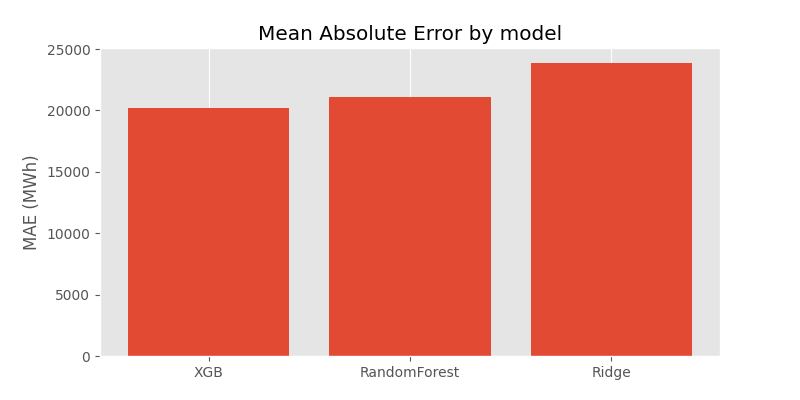

In [15]:
# Comparison metrics&table
results = metrics.sort_values('MAE').reset_index(drop=True)

styled = (results.style
          .format({'MAE':'{:.0f}', 'RMSE':'{:.0f}',
                   'MAPE_%':'{:.2f}', 'sMAPE_%':'{:.2f}', 'R2':'{:.3f}'})
          .highlight_min(subset=['MAE','RMSE','MAPE_%','sMAPE_%'],
                         color='lightgreen')
          .highlight_max(subset=['R2'], color='lightgreen')
          .set_caption('Model comparison on 2024 test set'))
display(styled)

plt.figure(figsize=(8,4))
plt.bar(results['model'], results['MAE'])
plt.ylabel('MAE (MWh)')
plt.title('Mean Absolute Error by model')
plt.grid(axis='y')
plt.show()